#  Analytics Experience - Group Project - MSCI:6040 

By Group 2 (Chris Wagner, Palden Williams, Tarun Mandava  - Data Scientists) 
- September, 2020                                                             

Objective - This project is an exercise in using natural language processing to determine if social media posts meet a pre-specified criterion.  In this case, the test is to determine which social media posts truly reflect information tied to a natural disaster.  For this exercise, we are working with a test dataset of Twitter posts that have been manually reviewed from Kraggle.

Data source:  Real or Not?  NLP with Disaster Tweets dataset from Kaggle

https://www.kaggle.com/c/nlp-getting-started

### Spacy Library generated Vectorization with SVC Model

This sample is looking at using the Spacy Library with its precompiled vectors to generate a Glove-like vectorization for our model.  Again, we'll use the Support Vector Classification out of the SVM library in SKLearn for the predictive modelling.

###### Acknowledgements/Sources

https://faculty.ai/blog/glove/<br>
https://nlp.stanford.edu/projects/glove/<br>
https://www.kaggle.com/spurryag/beginner-attempt-at-nlp-workflow


#### Library Imports

In [1]:
import spacy
import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sn
import matplotlib.pyplot as plt                     
import numpy as np           
import plotly.offline as plyo

In [2]:
import random
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import defaultdict
import string

from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm


stop = stopwords.words('english')
sn.set_context('notebook')

#### Read in the Kaggle datasets

In [3]:
sample_submission_data = pd.read_csv("Data/OriginalData/sample_submission.csv")
test_data = pd.read_csv("Data/OriginalData/test.csv")
train_data = pd.read_csv("Data/OriginalData/train.csv")

#### Remove any html characters

In [4]:
import re
def  remove_html(df, text):
    df[text] = df[text].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

test_clean = remove_html(test_data, "text")
train_clean = remove_html(train_data, "text")

#### Remove any Emojii's from the text

In [5]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

test_clean['text']=test_clean['text'].apply(lambda x: remove_emoji(x))
train_clean['text']=train_clean['text'].apply(lambda x: remove_emoji(x))

#### Data Cleaning

The following functions will be used to remove punctuation and stopwords, set common lemmatizations, and force the data to lowercase from the incomming text data

In [6]:
#code provided by http://https://www.kaggle.com/spurryag/beginner-attempt-at-nlp-workflow

nlp = spacy.load('en_core_web_md')
# Clean text before feeding it to model
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, puncuation and reducing all characters to lowercase 
def cleanup_text(docs, logging=False):
    texts = []
    for doc in tqdm(docs):
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        #remove stopwords and punctuations 
        tokens = [tok for tok in tokens if tok not in stop and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [7]:
train_data['token'] = cleanup_text(train_data['text'],logging=False)
test_data['token'] = cleanup_text(test_data['text'],logging=False)

100%|█████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:08<00:00, 393.84it/s]


#### Vectorizing the data

The following code will create a class that will inherit from the sklearn BaseEstimator and TransformerMixin libraries.  It overrides the fit and transform functions to utilize the internal nlp object for creating the model vectors.

In [8]:
# code provided by faculty.ai at https://faculty.ai/blog/glove/

#Note:  This code is included in the GloveVec.py file in the project folder

#import numpy as np
#import spacy
#from sklearn.base import BaseEstimator, TransformerMixin

#class GloveVectorizer(BaseEstimator, TransformerMixin):
#    def __init__(self, model_name="en_core_web_md"):
#        self._nlp = spacy.load(model_name)
#
#    def fit(self, X, y=None):
#        return self
#
#    def transform(self, X):
#        return np.concatenate(
#            [self._nlp(doc).vector.reshape(1, -1) for doc in X]
#        )

In [9]:
#importing the GloveVectorizer from the py file.  This also allows calling the glove vectorizer from the flask app
from GloveVec import GloveVectorizer

In order to identify the contents, we created specific variables for the X and Y training values, and an X_Test used to pull the return values to return to Kaggle for scoring.

In [10]:
X=train_data["token"]
y=train_data["target"]
X_Test = test_data["token"]

#### Model the training set of Twitter data

A pipeline was used to create an instance of the GloveVectorizer class as well as a new SVC model.  After the model is created, it is fit with the X and Y values from the training set above.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import svm

In [12]:
g = GloveVectorizer()
svm = svm.SVC()

pline = make_pipeline(g,svm)

pline.fit(X,y)

C:\Users\chris\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



Pipeline(memory=None,
         steps=[('glovevectorizer', GloveVectorizer(model_name=None)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Model has been created, let's review the score with the training set:

In [13]:
s = pline.score(X,y)

In [14]:
s

0.8534086431104689

Now we'll pull the sample submission dataset, score it against our model, and retrun the value to Kaggle for evaluation

In [15]:
sub = pd.read_csv('Data/OriginalData/sample_submission.csv')

In [16]:
sub.target = pline.predict(X_Test)
sub.to_csv("spacy_svm_glove_submission_clean.csv",index=False)

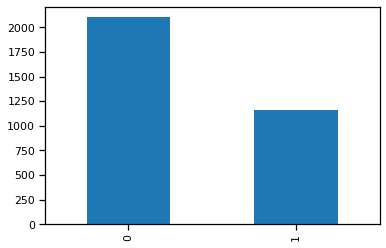

In [17]:
sub.target.value_counts().plot.bar();

#### Package the model into a pickle file for later use

The model will be stored in a pickle file so it can be called later from the flask application

In [18]:
import joblib

joblib.dump(pline, 'svm_model.pkl')

['svm_model.pkl']

#### Test against live tweets

For a further example, we pulled a sample of 100 tweets from Twitter with the keyword "wildfires".  Let's apply that to the model to see how it performed as well.

In [19]:
tweets = pd.read_csv("recent_tweets.csv")

#store the original tweet for comparison
tweets['OriginalText'] = tweets['Text']

tweets = remove_html(tweets,"Text")
tweets['Text']=tweets['Text'].apply(lambda x: remove_emoji(x))

tweets['token'] = cleanup_text(tweets['Text'],logging=False)

t_test = tweets["token"]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.75it/s]


In [20]:
#predict the disaster tweets

tweets["Target"] = pline.predict(t_test)

In [21]:
tweets.head()

,CreatedOn,ID,Text,User,Location,OriginalText,token,Target
0,2020-11-06 02:28:15,1324539060409540613,John Mayers wildfire is my favorite Frank Oce...,puta_kinte,NaN,@blondedocean John Mayer’s wildfire is my favo...,john mayers wildfire favorite frank ocean feat...,0
1,2020-11-06 02:22:10,1324537529446662144,Im afraid that I might be starting down a slip...,Wildfire_draft,"Vestal, NY",I'm afraid that I might be starting down a sli...,afraid may start slippery slope,0
2,2020-11-06 02:22:09,1324537525235580932,Running out of wildfire names Bay season goes ...,DeathLocal,NaN,"Running out of wildfire names, Bay season goes...",run wildfire name bay season go russian,1
3,2020-11-06 02:22:04,1324537504016474113,In California insurers are barred from canceli...,techchronicle,San Francisco,"In California, insurers are barred from cancel...",california insurer bar cancel renew home year ...,1
4,2020-11-06 02:21:39,1324537400954101760,Look I know you followed me for wildfire conte...,ericbkennedy,"Toronto, Ontario","Look, I know you followed me for wildfire cont...",look know follow wildfire content also go ampl...,0


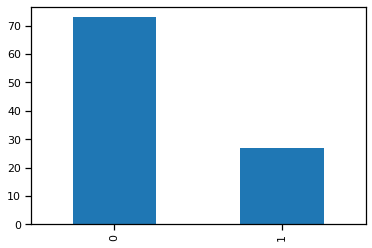

In [22]:
#compare the results of disaster vs. non-disaster

tweets.Target.value_counts().plot.bar();

In [23]:
#Load the results to a csv to review the final results

tweets.to_csv("recent_tweets_scored.csv",index=False)